# Load Packages

In [0]:
%%capture
!pip install "tensorflow>=2.0.0"
!pip install git+https://github.com/kmedian/keras-layernorm-rnn.git
!pip install lagmat

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from keras_layernorm_rnn import (
    LayernormSimpleRNN, LayernormLSTM1, LayernormLSTM2, LayernormLSTM3)
from lagmat import lagmat

import matplotlib.pyplot as plt
%matplotlib inline

# Generate Fake Dataset

In [0]:
n_obs = 2000    
delta = 0.05 
sigma = 0.5

t = np.arange(0, n_obs)
dat = np.cos(delta * t) + sigma * np.random.randn(n_obs)

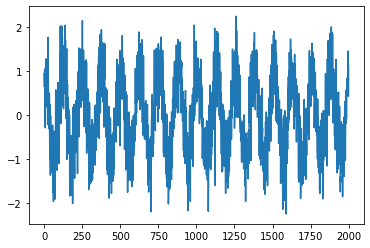

In [4]:
plt.plot(t, dat);

In [0]:
n_inp_steps = int(1. / delta)
n_out_steps = 1

mat = lagmat(dat, lags=range(n_inp_steps + n_out_steps))

In [6]:
print(mat[:6, :6])

[[0.94545746        nan        nan        nan        nan        nan]
 [0.75505165 0.94545746        nan        nan        nan        nan]
 [0.6400153  0.75505165 0.94545746        nan        nan        nan]
 [1.03599796 0.6400153  0.75505165 0.94545746        nan        nan]
 [0.99652734 1.03599796 0.6400153  0.75505165 0.94545746        nan]
 [0.97501666 0.99652734 1.03599796 0.6400153  0.75505165 0.94545746]]


In [0]:
# chop the nan away
idx_start = n_inp_steps + n_out_steps - 1
mat = mat[idx_start:, :]

In [0]:
# divide into y, X
X, y = mat[:, :n_inp_steps], mat[:, n_inp_steps:]

In [0]:
# data splitting
n_train = int(n_obs * 0.8)
X_train, X_valid = X[:n_train, :], X[n_train:, :]
Y_train, Y_valid = y[:n_train, :], y[n_train:, :]

In [0]:
# reshape for Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_train = Y_train.reshape(-1, 1)
Y_valid = Y_valid.reshape(-1, 1)

In [11]:
X_valid.shape, Y_valid.shape

((380, 20, 1), (380, 1))

# Modelling

# model1 - SimpleRNN

In [0]:
n_features = 1   # Input sequence is a simple univariate time series
n_targets = 1  # Output sequence is a simple univariate time series
n_rnn = 8
n_relu = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

opt_args = {
    'loss': 'mean_squared_error',
    'optimizer': tf.keras.optimizers.Adam(1e-4)
}

model1.compile(**opt_args)

## model2 - LayernormSimpleRNN

In [0]:
model2 = tf.keras.Sequential([
    LayernormSimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])


model2.compile(**opt_args)

## model 3 - LSTM

In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model3.compile(**opt_args)

## model4-6 - LayernormLSTM1-3

In [0]:
model4 = tf.keras.Sequential([
    LayernormLSTM1(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model4.compile(**opt_args)

In [0]:
model5 = tf.keras.Sequential([
    LayernormLSTM2(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model5.compile(**opt_args)

In [0]:
model6 = tf.keras.Sequential([
    LayernormLSTM3(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model6.compile(**opt_args)

# Training

In [0]:
train_args = {
    'epochs': 50,
    'batch_size': 16, 
    'steps_per_epoch': n_train // 16,
    'validation_data': (X_valid, Y_valid),
    'verbose': 0
}

In [19]:
%%time
history1 = model1.fit(X_train, Y_train, **train_args)

CPU times: user 1min 13s, sys: 4.98 s, total: 1min 18s
Wall time: 51.8 s


In [20]:
%%time
history2 = model2.fit(X_train, Y_train, **train_args)

CPU times: user 1min 37s, sys: 4.83 s, total: 1min 42s
Wall time: 1min 14s


In [21]:
%%time
history3 = model3.fit(X_train, Y_train, **train_args)

CPU times: user 24 s, sys: 2.05 s, total: 26.1 s
Wall time: 23 s


In [22]:
%%time
history4 = model4.fit(X_train, Y_train, **train_args)

CPU times: user 4min 17s, sys: 7.49 s, total: 4min 25s
Wall time: 3min 43s


In [23]:
%%time
history5 = model5.fit(X_train, Y_train, **train_args)

CPU times: user 3min 45s, sys: 6.47 s, total: 3min 52s
Wall time: 3min 13s


In [24]:
%%time
history6 = model6.fit(X_train, Y_train, **train_args)

CPU times: user 4min 12s, sys: 7.03 s, total: 4min 19s
Wall time: 3min 40s


# Check Gamma Weights

In [25]:
for arr in model4.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[0.929 1.006 0.944 0.962 0.988 0.968 1.052 0.96 ]
[1.05  1.018 1.035 1.032 1.059 0.996 1.079 0.869]
[1.119 0.985 1.062 0.999 0.952 1.095 1.023 1.078]
[1.095 1.078 0.974 1.087 0.991 1.004 0.924 0.888]


In [26]:
for arr in model5.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[1.041 1.002 1.007 1.029 0.942 0.989 0.975 0.95 ]
[0.973 0.966 0.959 0.997 0.971 0.99  0.994 0.979]
[0.991 0.961 0.995 0.987 1.054 1.005 1.    0.978]
[1.001 0.932 0.979 0.998 0.988 0.928 0.962 0.926]


In [27]:
for arr in model6.layers[0].cell.get_weights()[12:]:
    print(np.round(arr, 3))

[0.993 1.016 1.039 0.902 1.031 1.017 1.023 1.054]
[0.975 1.045 1.031 1.037 0.996 0.978 0.982 1.017]
[1.051 0.933 0.92  0.951 0.964 1.031 0.971 0.934]
[0.985 1.036 1.077 0.912 0.928 1.052 1.016 1.107]


# Compare

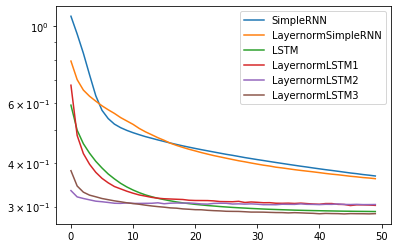

In [28]:
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.legend(["SimpleRNN", "LayernormSimpleRNN", "LSTM",
            "LayernormLSTM1", "LayernormLSTM2", "LayernormLSTM3"])
plt.yscale("log")
plt.show()